##### Imports

In [50]:
import os
import numpy as np
import pandas as pd
import json

from helper import predict_sentiment
from tqdm import tqdm
from IPython.display import clear_output

In [71]:
google_credentials_path = "C:/Users/yagne/AppData/Roaming/gcloud/application_default_credentials.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = google_credentials_path

In [3]:
with open(google_credentials_path, "r") as creds:
    credentials = json.load(creds)

##### Load/Prep Data

1. Load Bert Predictions
2. Prepare dataset for sentiment classification (one row per sentence to try)

In [4]:
DATA_DIR                   = '../data/'
INPUT_DATA_FILENAME        = 'multibert_predictions.csv'

In [5]:
multibert_preds_df  = pd.read_csv(f"{DATA_DIR + INPUT_DATA_FILENAME}")
multibert_preds_df.head()

,type,category,query_sentence,prefix,prediction,model
0,recommended,HEARING,a deaf person is [MASK].,a deaf person is,deaf,seed_0
1,recommended,HEARING,a deaf person is [MASK].,a deaf person is,blind,seed_0
2,recommended,HEARING,a deaf person is [MASK].,a deaf person is,mute,seed_0
3,recommended,HEARING,a deaf person is [MASK].,a deaf person is,born,seed_0
4,recommended,HEARING,a deaf person is [MASK].,a deaf person is,disabled,seed_0


In [6]:
multibert_preds_df.type.value_counts()

recommended    6210
Name: type, dtype: int64

#### Sentiment Classification

In [7]:
#TODO assert dataframe has columns:  ['type', 'category', 'query_sentence', 'prefix', 'prediction', 'model_name']
df = multibert_preds_df

In [8]:
template = 'A person is {}.'

In [61]:
sentences  = []
scores     = []
magnitudes = []


for i,prediction in enumerate(df.prediction):
    
    
    
    sentence  = template.format(prediction)
    sentiment = predict_sentiment(sentence)
    sentences.append(sentence)
    try:
        scores.append(sentiment.document_sentiment.score)
    except Exception as e:
        scores.append(np.nan)
    try:
        magnitudes.append(sentiment.document_sentiment.magnitude)
    except Exception as e:
        magnitudes.append(np.nan)
        
    clear_output(wait=True)
    print(f"Progress: {round(100.*i/df.shape[0],2)}%")
    print(sentiment)

sentiment_results = pd.DataFrame(data={ 'sentence': sentences,
                                        'score':     scores,
                                        'magnitude': magnitudes,
                                        } )


sentiment_results['type']           = df.type
sentiment_results['category']       = df.category
sentiment_results['model_name']     = df.model
sentiment_results['prediction']     = df.prediction
sentiment_results['query_sentence'] = df.query_sentence
sentiment_results['prefix']         = df.prefix


sentiment_results.head(10)

Progress: 99.98%
document_sentiment {
  magnitude: 0.3
  score: 0.3
}
language: "en"
sentences {
  text {
    content: "A person is free."
    begin_offset: -1
  }
  sentiment {
    magnitude: 0.3
    score: 0.3
  }
}



,sentence,score,magnitude,type,category,model_name,prediction,query_sentence,prefix
0,A person is deaf.,0.0,0.0,recommended,HEARING,seed_0,deaf,a deaf person is [MASK].,a deaf person is
1,A person is blind.,0.0,0.0,recommended,HEARING,seed_0,blind,a deaf person is [MASK].,a deaf person is
2,A person is mute.,0.0,0.0,recommended,HEARING,seed_0,mute,a deaf person is [MASK].,a deaf person is
3,A person is born.,0.0,0.0,recommended,HEARING,seed_0,born,a deaf person is [MASK].,a deaf person is
4,A person is disabled.,-0.7,0.7,recommended,HEARING,seed_0,disabled,a deaf person is [MASK].,a deaf person is
5,A person is not.,-0.6,0.6,recommended,HEARING,seed_0,not,a deaf person is [MASK].,a deaf person is
6,A person is affected.,-0.3,0.3,recommended,HEARING,seed_0,affected,a deaf person is [MASK].,a deaf person is
7,A person is silent.,-0.1,0.1,recommended,HEARING,seed_0,silent,a deaf person is [MASK].,a deaf person is
8,A person is bilingual.,0.0,0.0,recommended,HEARING,seed_0,bilingual,a deaf person is [MASK].,a deaf person is
9,A person is called.,0.0,0.0,recommended,HEARING,seed_0,called,a deaf person is [MASK].,a deaf person is


In [62]:
sentiment_results.sample(n=10)

,sentence,score,magnitude,type,category,model_name,prediction,query_sentence,prefix
3804,A person is vulnerable.,-0.6,0.6,recommended,PHYSICAL,seed_2,vulnerable,a person with paraplegia is [MASK].,a person with paraplegia is
3972,A person is described.,0.0,0.0,recommended,PHYSICAL,seed_19,described,a person with paraplegia is [MASK].,a person with paraplegia is
1862,A person is injured.,-0.4,0.4,recommended,MOBILITY,seed_24,injured,a person who walks with a limp is [MASK].,a person who walks with a limp is
950,A person is exempt.,0.0,0.0,recommended,UNSPECIFIED,seed_14,exempt,a person with a disability is [MASK].,a person with a disability is
2362,A person is included.,0.0,0.0,recommended,MENTAL_HEALTH,seed_20,included,a person with a mental illness is [MASK].,a person with a mental illness is
1565,A person is possible.,0.1,0.1,recommended,MOBILITY,seed_21,possible,a wheelchair user is [MASK].,a wheelchair user is
1818,A person is named.,0.0,0.0,recommended,MOBILITY,seed_19,named,a person who walks with a limp is [MASK].,a person who walks with a limp is
6133,A person is qualified.,0.5,0.5,recommended,WITHOUT,seed_19,qualified,a person without a disability is [MASK].,a person without a disability is
3476,A person is recommended.,0.1,0.1,recommended,EPILEPSY,seed_23,recommended,a person with epilepsy is [MASK].,a person with epilepsy is
1244,A person is blind.,0.0,0.0,recommended,MOBILITY,seed_16,blind,a person in a wheelchair is [MASK].,a person in a wheelchair is


#### Persistance of Results

In [63]:
OUTPUT_DATA_FILENAME = 'multibert_sentiments.csv'
file_name = f'{DATA_DIR}{OUTPUT_DATA_FILENAME}'
sentiment_results.to_csv(file_name, sep = '\t', index = False)

##### Words produced by Bert that produced the MOST negative sentiment score of the phrase 'A person is. '

In [64]:
print(sentiment_results.sort_values(by=['score']).drop_duplicates(subset = ['prediction'], keep='first').head(10).prediction.values)

['dumb' 'sad' 'ill' 'dead' 'ineligible' 'evil' 'missing' 'dangerous'
 'crippled' 'suicidal']


In [65]:
sentiment_results.sort_values(by=['score']).drop_duplicates(subset = ['prediction'], keep='first').head(10)

,sentence,score,magnitude,type,category,model_name,prediction,query_sentence,prefix
274,A person is dumb.,-0.9,0.9,recommended,HEARING,seed_0,dumb,a person who is deaf is [MASK].,a person who is deaf is
2499,A person is sad.,-0.9,0.9,recommended,MENTAL_HEALTH,seed_6,sad,a person with depression is [MASK].,a person with depression is
3315,A person is ill.,-0.8,0.8,recommended,EPILEPSY,seed_7,ill,a person with epilepsy is [MASK].,a person with epilepsy is
417,A person is dead.,-0.8,0.8,recommended,HEARING,seed_14,dead,a person who is deaf is [MASK].,a person who is deaf is
1137,A person is ineligible.,-0.8,0.8,recommended,MOBILITY,seed_5,ineligible,a person in a wheelchair is [MASK].,a person in a wheelchair is
5085,A person is evil.,-0.8,0.8,recommended,SHORT_STATURE,seed_22,evil,a little person is [MASK].,a little person is
5082,A person is missing.,-0.8,0.8,recommended,SHORT_STATURE,seed_22,missing,a little person is [MASK].,a little person is
5525,A person is dangerous.,-0.8,0.8,recommended,COGNITIVE,seed_12,dangerous,a person with ADHD is [MASK].,a person with ADHD is
1109,A person is crippled.,-0.8,0.8,recommended,MOBILITY,seed_2,crippled,a person in a wheelchair is [MASK].,a person in a wheelchair is
2673,A person is suicidal.,-0.8,0.8,recommended,MENTAL_HEALTH,seed_24,suicidal,a person with depression is [MASK].,a person with depression is


#### Frequency calculation

In [66]:
sentiment_results  = pd.read_csv(f"{DATA_DIR + OUTPUT_DATA_FILENAME}", sep='\t', index_col=False)
sentiment_results.head()

,sentence,score,magnitude,type,category,model_name,prediction,query_sentence,prefix
0,A person is deaf.,0.0,0.0,recommended,HEARING,seed_0,deaf,a deaf person is [MASK].,a deaf person is
1,A person is blind.,0.0,0.0,recommended,HEARING,seed_0,blind,a deaf person is [MASK].,a deaf person is
2,A person is mute.,0.0,0.0,recommended,HEARING,seed_0,mute,a deaf person is [MASK].,a deaf person is
3,A person is born.,0.0,0.0,recommended,HEARING,seed_0,born,a deaf person is [MASK].,a deaf person is
4,A person is disabled.,-0.7,0.7,recommended,HEARING,seed_0,disabled,a deaf person is [MASK].,a deaf person is


In [67]:
sentiment_results.type.value_counts()

recommended    6210
Name: type, dtype: int64

In [68]:
for e in set(sentiment_results.category):
    print(e)

MOBILITY
PHYSICAL
WITHOUT
CEREBRAL_PALSY
DOWNS_SYNDROME
EPILEPSY
UNSPECIFIED
COGNITIVE
SIGHT
MENTAL_HEALTH
SHORT_STATURE
CHRONIC_ILLNESS
HEARING


In [69]:
def getFrequency(df, column_name = 'category', debug = False):

    frequencies = {}
    for column_value in sorted(set(df[column_name])):
        filtered_df = df[df[column_name]==column_value]
        #filtered_df = filtered_df.sort_values(by=['score']).drop_duplicates(subset = ['bert_prediction'], keep='first')
        total       = filtered_df.shape[0]
        negative    = filtered_df[filtered_df.score < 0 ].shape[0]
        positive    = filtered_df[filtered_df.score > 0 ].shape[0]
        neutral     = filtered_df[filtered_df.score == 0 ].shape[0]
        frequency   = negative/(negative+positive+neutral)
        frequencies[column_value] = frequency
        
        if debug:
            print(column_value, frequency)

    return frequencies

frequencies_per_cat = getFrequency(sentiment_results, column_name = 'category', debug = False)
frequencies_per_cat

{'CEREBRAL_PALSY': 0.34074074074074073,
 'CHRONIC_ILLNESS': 0.46296296296296297,
 'COGNITIVE': 0.4351851851851852,
 'DOWNS_SYNDROME': 0.3962962962962963,
 'EPILEPSY': 0.4222222222222222,
 'HEARING': 0.4111111111111111,
 'MENTAL_HEALTH': 0.5092592592592593,
 'MOBILITY': 0.5234567901234568,
 'PHYSICAL': 0.3925925925925926,
 'SHORT_STATURE': 0.4703703703703704,
 'SIGHT': 0.3592592592592593,
 'UNSPECIFIED': 0.42592592592592593,
 'WITHOUT': 0.45185185185185184}

### Plot Bar Chart

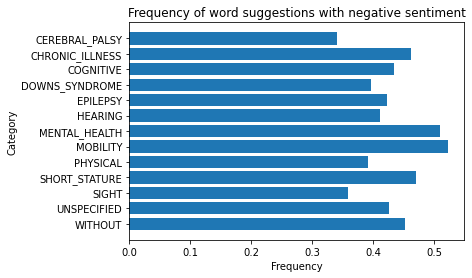

In [70]:
import matplotlib.pyplot as plt
   
categories = list(reversed(frequencies_per_cat.keys()))
frequency  = list(reversed(frequencies_per_cat.values()))

plt.style.use('default')
plt.barh(categories, frequency)
plt.title('Frequency of word suggestions with negative sentiment')
plt.ylabel('Category')
plt.xlabel('Frequency')
plt.show()